#**This code is linear probing of home/shashank/dataset/Reconstruction/convMAEImplementation/**

In [1]:
!pip install scikit-learn

In [2]:
import torch
import torch_xla
import torch_xla.core.xla_model as xm

import pandas as pd
import numpy as np
import csv
import torch
import ctypes
import gc
import os

import dataset
import torch
import warnings

import pandas as pd
import numpy as np
import torch.nn as nn

# from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

os.environ['PJRT_DEVICE'] = 'TPU' 
warnings.filterwarnings("ignore")
libc = ctypes.CDLL("libc.so.6")
torch.manual_seed(42)

import pandas as pd
import numpy as np
import csv
import torch
import ctypes
import gc
libc = ctypes.CDLL("libc.so.6")

from functools import partial

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.helpers import load_pretrained
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.resnet import resnet26d, resnet50d
from timm.models.registry import register_model

import torch.nn as nn
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype='float32')
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(embed_dim)
        self.act = nn.GELU()
    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x)
        x = self.norm(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        return self.act(x)
    
class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x
    
    
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class CBlock(nn.Module):
    # taken from https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.conv1 = nn.Conv2d(dim, dim, 1)
        self.conv2 = nn.Conv2d(dim, dim, 1)
        self.attn = nn.Conv2d(dim, dim, 5, padding=2, groups=dim)
#        self.attn = nn.Conv2d(dim, dim, 13, padding=6, groups=dim)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = CMlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, mask=None):
        if mask is not None:
            x = x + self.drop_path(self.conv2(self.attn(mask * self.conv1(self.norm1(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)))))
        else:
            x = x + self.drop_path(self.conv2(self.attn(self.conv1(self.norm1(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)))))
        x = x + self.drop_path(self.mlp(self.norm2(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)))
        return x
    
class CMlp(nn.Module):
    # taken from https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Conv2d(in_features, hidden_features, 1)
        self.act = act_layer()
        self.fc2 = nn.Conv2d(hidden_features, out_features, 1)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x



In [3]:
# Copyright (c) 2022 Alpha-VL
# --------------------------------------------------------
# References:
# timm: https://github.com/rwightman/pytorch-image-models/tree/master/timm
# DeiT: https://github.com/facebookresearch/deit
# MAE: https://github.com/facebookresearch/mae
# --------------------------------------------------------

from functools import partial
import pdb
import torch
import torch.nn as nn


class MaskedAutoencoderConvViT(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=True):
        super().__init__()
        # --------------------------------------------------------------------------
        # ConvMAE encoder specifics
        self.patch_embed1 = PatchEmbed(
                img_size=img_size[0], patch_size=patch_size[0], in_chans=in_chans, embed_dim=embed_dim[0])
        self.patch_embed2 = PatchEmbed(
                img_size=img_size[1], patch_size=patch_size[1], in_chans=embed_dim[0], embed_dim=embed_dim[1])
        self.patch_embed3 = PatchEmbed(
                img_size=img_size[2], patch_size=patch_size[2], in_chans=embed_dim[1], embed_dim=embed_dim[2])

        self.patch_embed4 = nn.Linear(embed_dim[2], embed_dim[2])
        self.stage1_output_decode = nn.Conv2d(embed_dim[0], embed_dim[2], 4, stride=4)
        self.stage2_output_decode = nn.Conv2d(embed_dim[1], embed_dim[2], 2, stride=2)

        num_patches = self.patch_embed3.num_patches
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim[2]), requires_grad=False)
        self.blocks1 = nn.ModuleList([
            CBlock(
                dim=embed_dim[0], num_heads=num_heads, mlp_ratio=mlp_ratio[0],  qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(depth[0])])
        self.blocks2 = nn.ModuleList([
            CBlock(
                dim=embed_dim[1], num_heads=num_heads, mlp_ratio=mlp_ratio[1],  qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(depth[1])])
        self.blocks3 = nn.ModuleList([
            Block(
                dim=embed_dim[2], num_heads=num_heads, mlp_ratio=mlp_ratio[2],  qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(depth[2])])
        self.norm = norm_layer(embed_dim[-1])

        # --------------------------------------------------------------------------
        # ConvMAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim[-1], decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding
        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio[0], qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, (patch_size[0] * patch_size[1] * patch_size[2])**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed3.num_patches**.5), cls_token=False)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed3.num_patches**.5), cls_token=False)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed3.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
#        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = 16
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 8, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 8))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed1.patch_size[0]*self.patch_embed2.patch_size[0]*self.patch_embed3.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        #(n, 196, 2048) -> (n, 14, 14, 16, 16, 8)
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N = x.shape[0]
        L = self.patch_embed3.num_patches
#        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
#        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return ids_keep, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        ids_keep, mask, ids_restore = self.random_masking(x, mask_ratio)
        mask_for_patch1 = mask.reshape(-1, 14, 14).unsqueeze(-1).repeat(1, 1, 1, 16).reshape(-1, 14, 14, 4, 4).permute(0, 1, 3, 2, 4).reshape(x.shape[0], 56, 56).unsqueeze(1)
        mask_for_patch2 = mask.reshape(-1, 14, 14).unsqueeze(-1).repeat(1, 1, 1, 4).reshape(-1, 14, 14, 2, 2).permute(0, 1, 3, 2, 4).reshape(x.shape[0], 28, 28).unsqueeze(1)
        x = self.patch_embed1(x)
        for blk in self.blocks1:
            x = blk(x, 1 - mask_for_patch1)
        stage1_embed = self.stage1_output_decode(x).flatten(2).permute(0, 2, 1)

        x = self.patch_embed2(x)
        for blk in self.blocks2:
            x = blk(x, 1 - mask_for_patch2)
        stage2_embed = self.stage2_output_decode(x).flatten(2).permute(0, 2, 1)
        x = self.patch_embed3(x)
        x = x.flatten(2).permute(0, 2, 1)
        x = self.patch_embed4(x)
        # add pos embed w/o cls token
        x = x + self.pos_embed
        x = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, x.shape[-1]))
        stage1_embed = torch.gather(stage1_embed, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, stage1_embed.shape[-1]))
        stage2_embed = torch.gather(stage2_embed, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, stage2_embed.shape[-1]))


        # apply Transformer blocks
        for blk in self.blocks3:
            x = blk(x)
        x = x + stage1_embed + stage2_embed
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)
#         print(x.shape)
        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1]  - x.shape[1], 1)
        x_ = torch.cat([x, mask_tokens], dim=1)  # no cls token
        x = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
#         print(x.shape)
        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = self.patchify(imgs)
        criterion = nn.BCEWithLogitsLoss(reduction = "mean")
        loss = criterion(pred, target)
        
#         print(op.shape)
#         print(target.shape)
#         if self.norm_pix_loss:
#             mean = target.mean(dim=-1, keepdim=True)
#             var = target.var(dim=-1, keepdim=True)
#             target = (target - mean) / (var + 1.e-6)**.5

#         loss = (pred - target) ** 2
#         loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

#         loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        
        return loss

    def forward(self, imgs, mask_ratio=0.75):
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        loss = self.forward_loss(imgs, pred, mask)
        unpatchified_img = self.unpatchify(pred)
        return loss, pred, unpatchified_img


def convmae_convvit_base_patch16_dec512d8b(**kwargs):
    model = MaskedAutoencoderConvViT(
        img_size=[224, 56, 28], patch_size=[4, 2, 2], embed_dim=[64, 128, 256], depth=[2, 2, 16], num_heads=8,
        decoder_embed_dim=256, decoder_depth=8, decoder_num_heads=8, in_chans=8,
        mlp_ratio=[4, 4, 4], norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


# set recommended archs
model = convmae_convvit_base_patch16_dec512d8b()  # decoder: 512 dim, 8 blocks
model.load_state_dict(torch.load('/home/shashank/notebooks/Trained models/Reconstruction/ConvMAE implementation/conv_mae_model_epoch.pth'))

<All keys matched successfully>

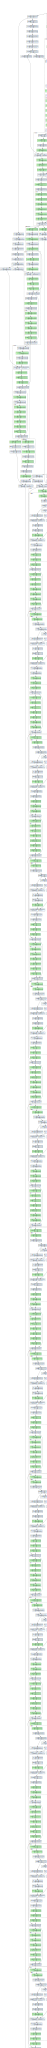

In [4]:
import torchvision
from torchview import draw_graph
from torchviz import make_dot
model_graph = draw_graph(model, input_size=(1,8,224,224), expand_nested=True)
model_graph.visual_graph

In [5]:
import os
import numpy as np
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import gc

def load_image(path):
    with Image.open(path) as f:
        img_array = np.array(f).reshape((125, 125, 8)).astype('float32')
    return img_array

def load_images_from_directory(directory, label):
    paths = [os.path.join(directory, file) for file in os.listdir(directory)][50000:100000]
    with ThreadPoolExecutor() as executor:
        images = list(tqdm(executor.map(load_image, paths), total=len(paths)))
    labels = [label] * len(images)
    return images, labels

# Load images from both directories
X_one, y_one = load_images_from_directory('/home/shashank/dataset/dataset/one/', 0)
X_two, y_two = load_images_from_directory('/home/shashank/dataset/dataset/two/', 1)

# Combine datasets
X = X_one + X_two
Y = y_one + y_two

100%|██████████| 50000/50000 [00:02<00:00, 18440.54it/s] 


In [6]:
from sklearn.utils import shuffle
X, Y = shuffle(X, Y, random_state = 42)
X_train = X[:int(len(X)*0.8)]
X_test = X[int(len(X)*0.8):len(X)]
Y_train = Y[:int(len(X)*0.8)]
Y_test = Y[int(len(X)*0.8):len(X)]
Y_train = np.array(Y_train).astype('float32')
Y_test = np.array(Y_test).astype('float32')
X_train = np.array(X_train).astype('float32')
X_test = np.array(X_test).astype('float32')

print(X_train.shape)
print(Y_train.shape)

(80000, 125, 125, 8)
(80000,)


In [7]:
import os
import torch
import pandas as pd
# from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class Custom_Dataset(Dataset):
    def __init__(self, x, y, transform):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_1 = torch.from_numpy(self.x[idx]).moveaxis(2, 0)/255.0
        # img = self.x[idx]
        label = torch.tensor(self.y[idx])

        if self.transform:
            img_1 = self.transform(img_1)
            
        sample = {'img' : img_1, 'label' : label}
        
        return sample

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
])

t_dataset = Custom_Dataset(X_train, Y_train, transform = transform)
y_dataset = Custom_Dataset(X_test, Y_test, transform = transform)
t_dataloader = DataLoader(t_dataset, batch_size = 8)
# t_dataloader = DataLoader(t_dataset, batch_size = 8)
sample = t_dataset.__getitem__(1)
print((sample['img']).max())
print(sample['label'])


tensor(1.)
tensor(1.)


In [8]:
class FromPretrainedDecoder(nn.Module):
    def __init__(self, pretrained_model, hidden_dim, num_classes):
        super().__init__()
        self.pretrained_model = pretrained_model
        
        for param in self.pretrained_model.parameters():
            param.requires_grad = False
            
        self.linear1 = nn.Linear(hidden_dim, 32)
        self.linear = nn.Linear(32, num_classes)
        self.linear2 = nn.Linear(hidden_dim, num_classes)
        self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        # x = self.pretrained_model.encoder._process_input(x)
        n = x.shape[0]

        encoded_tensor, masks, ids= self.pretrained_model.forward_encoder(x, mask_ratio = 0)
        # op = torch.cat(encoded_tensor, axis = 2)
        # print(encoded_tensor.shape)
        # x = op[:,:1,:].squeeze(1)
        x = encoded_tensor.mean(axis = 1)
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.linear2(x)
        
        return x

pretrained_model = FromPretrainedDecoder(pretrained_model=model,
                                         hidden_dim=256,
                                         num_classes=1)

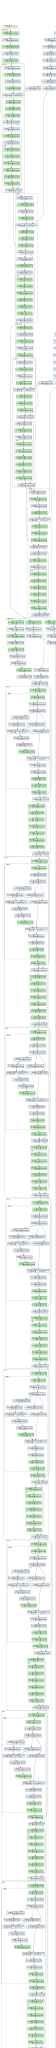

In [9]:
import torchvision
from torchview import draw_graph
from torchviz import make_dot

model_graph = draw_graph(pretrained_model, input_size=(1,8,224,224), expand_nested=True)
model_graph.visual_graph

In [10]:
# model.train()
for batch in t_dataloader:
    img = batch['img']
    lab = batch['label']
    break
pred = pretrained_model(img)
torch.sigmoid(pred)

tensor([[0.5037],
        [0.5052],
        [0.5084],
        [0.5028],
        [0.5034],
        [0.4972],
        [0.5058],
        [0.4982]], grad_fn=<SigmoidBackward0>)

In [11]:
criterion = nn.BCEWithLogitsLoss(reduction = "mean")
loss = criterion(pred.squeeze(), lab)
loss

tensor(0.6912, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [12]:
def reduce_fn(vals):
    # take average
    # xm.print(len(vals))
    return sum(vals) / len(vals)

In [13]:
def lr_lambda(epoch):
    warmup_epochs = 3
    decay_rate = 0.8
    if epoch < warmup_epochs:
        # Linear increase during warmup
        return float(epoch + 1) / warmup_epochs
    else:
        # Exponential decay after warmup
        return decay_rate ** (epoch - warmup_epochs + 1)

In [14]:
from tqdm import tqdm
from torchmetrics import Accuracy, AUROC
def train_one_epoch(epoch, epochs, model, train_dataloader, valid_dataloader, scheduler, device, optimizer):
    train_loss = []
    valid_loss = []
    accuracy = Accuracy(task = 'binary').to(device)
    auroc = AUROC(task='binary').to(device)
    criterion = nn.BCEWithLogitsLoss(reduction = "mean")
    # criterion = nn.BCELoss()
    
    train_accuracies = []
    val_accuracies = []
    train_aurocs = []
    val_aurocs = []
    
    model.train()
    # scheduler.step()

    for step, batch in tqdm(enumerate(train_dataloader), desc=f'Epoch {epoch+1}/{epochs} (Train)', unit='batch'):
        image = batch['img'].to(device)
        label = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(image)
        outputs = outputs.squeeze()
        
        loss = criterion(outputs, label)

        loss.backward()
        xm.optimizer_step(optimizer)
        loss_reduced = xm.mesh_reduce('loss_reduce',loss.item(),reduce_fn) 
        # outputs_reduced = xm.mesh_reduce('outputs_reduce',outputs.item(),reduce_fn) 
        
        train_loss.append(loss_reduced)
        train_acc = accuracy(outputs, label)
        train_auroc = auroc(outputs, label)
        
        train_acc_red = xm.mesh_reduce('loss_reduce',train_acc.item(),reduce_fn) 
        train_auc_red = xm.mesh_reduce('loss_reduce',train_auroc.item(),reduce_fn)
        
        train_aurocs.append(train_auc_red)
        train_accuracies.append(train_acc_red)
        
        # if step%50 == 0:
        #     xm.master_print(f'Train_Batch: {step}, reduced_loss: {loss_reduced}, loss: {loss.item()},  outputs: {outputs[0]}')
        gc.collect()

    model.eval()
    with torch.no_grad():
        for step, batch in tqdm(enumerate(valid_dataloader), desc=f'Epoch {epoch+1}/{epochs} (Train)', unit='batch'):
            image = batch['img'].to(device)
            label = batch['label'].to(device).squeeze()
            outputs = model(image)
            outputs = outputs.squeeze()
            
            loss = criterion(outputs, label)
            loss_reduced = xm.mesh_reduce('loss_reduce',loss.item(),reduce_fn) 
            valid_loss.append(loss_reduced)
            
            val_acc = accuracy(outputs, label)
            val_acc_red = xm.mesh_reduce('loss_reduce',val_acc.item(),reduce_fn) 
            val_accuracies.append(val_acc_red)

            val_auc = auroc(outputs, label)
            val_auc_red = xm.mesh_reduce('loss_reduce',val_auc.item(),reduce_fn) 
            val_aurocs.append(val_auc_red)

            
            # if step%10 == 0:
            #     xm.master_print(f'val_Batch: {step}, reduced_loss: {loss_reduced}, loss: {loss.item()}  outputs: {outputs[0]}')
            gc.collect()

    return np.mean(train_loss), np.mean(valid_loss) , np.mean(train_accuracies), np.mean(val_accuracies), np.mean(train_aurocs), np.mean(val_aurocs)


In [15]:
def data():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to 224x224
    ])

    ##Train Dataset
    train_dataset = Custom_Dataset(X_train, Y_train, transform = transform)
    
    ##Test Dataset
    test_dataset = Custom_Dataset(X_test, Y_test, transform = transform)
    
    ##Sampler
    train_sampler = torch.utils.data.distributed.DistributedSampler(
                                                                    train_dataset,
                                                                    num_replicas=xm.xrt_world_size(),
                                                                    rank=xm.get_ordinal(),
                                                                    shuffle = True
                                                                    )
    
    ##Train Dataloader
    dataloader_train = torch.utils.data.DataLoader(train_dataset,
                                                    batch_size=512,
                                                    sampler = train_sampler,
                                                    drop_last = True,
                                                    num_workers=1,
                                                    pin_memory = True)
    
    
    ##Sampler
    valid_sampler = torch.utils.data.distributed.DistributedSampler(
                                                                    test_dataset,
                                                                    num_replicas=xm.xrt_world_size(),
                                                                    rank=xm.get_ordinal(),
                                                                    shuffle = False
                                                                    )
    ##Test Dataloader
    dataloader_test = torch.utils.data.DataLoader(test_dataset,
                                                  sampler = valid_sampler,
                                                  batch_size=512,
                                                  drop_last = True,
                                                  num_workers=1,
                                                 )
    return dataloader_train, dataloader_test

In [16]:

def train_function(model, epochs, dev):
    lr = 1.5e-4
    num_train_steps = int(
        len(X_train) / 64 / xm.xrt_world_size() * epochs
    )

    lr = lr * xm.xrt_world_size()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay = 0.005)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    train_dataloader, test_dataloader = data()
    
    xm.master_print(f'num_training_steps = {num_train_steps}, world_size={xm.xrt_world_size()}')
    device = dev
    model = model.to(device)
    
    train_loss = []
    valid_loss = []
    for epoch in (range(epochs)):
        gc.collect()
        para_loader = pl.ParallelLoader(train_dataloader, [device])
        train_loader = para_loader.per_device_loader(device)

        val_loader = pl.ParallelLoader(test_dataloader, [device])
        valid_loader = val_loader.per_device_loader(device)
        
        trn_loss, val_loss, trn_acc, val_acc, trn_auc, val_auc = train_one_epoch(epoch, epochs, model, train_loader, valid_loader, scheduler, device, optimizer)
        
        scheduler.step()
        train_loss.append(trn_loss)
        valid_loss.append(val_loss)
        gc.collect()

        xm.master_print(f'Epoch {epoch+1}/{epochs}, Train Loss: {trn_loss:.4f}, Val Loss: {val_loss:.4f}, Train acc: {trn_acc:.4f}, Val acc: {val_acc:.4f}, Train auc: {trn_auc:.4f}, Val auc: {val_auc:.4f},')
        with open('pretrained.csv', 'a', newline='') as f:
            writer = csv.writer(f)
            if epoch == 0:
                writer.writerow(['Epoch', 'Train Loss', 'Val Loss', 'Train Acc', 'Val Acc', 'Train AUROC', 'Val AUROC'])
            writer.writerow([epoch+1, trn_loss, val_loss, trn_acc, val_acc, trn_auc, val_auc])
        
    xm.rendezvous('save_model')
    xm.master_print('save model')
    xm.save(model.state_dict(), f'./linear_probe_pretrained.pth')

def _mp_fn(rank, flags):
    try:
        pretrained_model = FromPretrainedDecoder(pretrained_model=model,
                                         hidden_dim=256,
                                         num_classes=1)
        dev = xm.xla_device()
        pretrained_model = pretrained_model.to(dev)
        dataloader_train, dataloader_test = data()
        torch.set_default_tensor_type('torch.FloatTensor')
        train_function(pretrained_model, epochs=10, dev = dev)
        # xser.save(model.state_dict(), f"model.bin", master_only=True)
    except Exception as e:
        print(f"Exception in process {rank}: {e}")
        raise

if __name__ == '__main__':
    FLAGS = {}
    try:
        xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')
    except Exception as e:
        print(f"Exception in main: {e}")

I0000 00:00:1721381955.974395 2234328 pjrt_api.cc:100] GetPjrtApi was found for tpu at /home/shashank/.local/lib/python3.10/site-packages/libtpu/libtpu.so


num_training_steps = 3125, world_size=4


Epoch 1/10 (Train): 39batch [02:17,  3.51s/batch]
Epoch 1/10 (Train): 39batch [02:17,  3.52s/batch]
Epoch 1/10 (Train): 39batch [02:17,  3.52s/batch]
Epoch 1/10 (Train): 39batch [02:17,  3.52s/batch]
Epoch 1/10 (Train): 9batch [00:44,  4.98s/batch]
Epoch 1/10 (Train): 9batch [00:44,  4.98s/batch]
Epoch 1/10 (Train): 9batch [00:44,  4.97s/batch]
Epoch 1/10 (Train): 9batch [00:44,  4.99s/batch]


Epoch 1/10, Train Loss: 0.6791, Val Loss: 0.6932, Train acc: 0.6275, Val acc: 0.5033, Train auc: 0.6652, Val auc: 0.6637,


Epoch 2/10 (Train): 39batch [01:27,  2.24s/batch]
Epoch 2/10 (Train): 39batch [01:27,  2.25s/batch]
Epoch 2/10 (Train): 39batch [01:27,  2.25s/batch]
Epoch 2/10 (Train): 39batch [01:27,  2.24s/batch]
Epoch 2/10 (Train): 9batch [00:15,  1.75s/batch]
Epoch 2/10 (Train): 9batch [00:15,  1.76s/batch]
Epoch 2/10 (Train): 9batch [00:15,  1.77s/batch]
Epoch 2/10 (Train): 9batch [00:15,  1.77s/batch]


Epoch 2/10, Train Loss: 0.6611, Val Loss: 0.6798, Train acc: 0.6314, Val acc: 0.6249, Train auc: 0.6819, Val auc: 0.6775,


Epoch 3/10 (Train): 39batch [01:56,  2.99s/batch]
Epoch 3/10 (Train): 39batch [01:57,  3.00s/batch]
Epoch 3/10 (Train): 39batch [01:56,  2.99s/batch]
Epoch 3/10 (Train): 39batch [01:56,  2.99s/batch]
Epoch 3/10 (Train): 9batch [00:08,  1.10batch/s]
Epoch 3/10 (Train): 9batch [00:08,  1.10batch/s]
Epoch 3/10 (Train): 9batch [00:08,  1.10batch/s]
Epoch 3/10 (Train): 9batch [00:08,  1.10batch/s]


Epoch 3/10, Train Loss: 0.6443, Val Loss: 0.6438, Train acc: 0.6362, Val acc: 0.6356, Train auc: 0.6916, Val auc: 0.6913,


Epoch 4/10 (Train): 39batch [01:17,  1.98s/batch]
Epoch 4/10 (Train): 39batch [01:17,  1.98s/batch]
Epoch 4/10 (Train): 39batch [01:17,  1.98s/batch]
Epoch 4/10 (Train): 39batch [01:17,  1.98s/batch]
Epoch 4/10 (Train): 9batch [00:06,  1.49batch/s]
Epoch 4/10 (Train): 9batch [00:06,  1.49batch/s]
Epoch 4/10 (Train): 9batch [00:06,  1.49batch/s]
Epoch 4/10 (Train): 9batch [00:06,  1.49batch/s]


Epoch 4/10, Train Loss: 0.6330, Val Loss: 0.6324, Train acc: 0.6464, Val acc: 0.6453, Train auc: 0.7054, Val auc: 0.7034,


Epoch 5/10 (Train): 39batch [01:15,  1.94s/batch]
Epoch 5/10 (Train): 39batch [01:15,  1.92s/batch]
Epoch 5/10 (Train): 39batch [01:15,  1.93s/batch]
Epoch 5/10 (Train): 39batch [01:14,  1.92s/batch]
Epoch 5/10 (Train): 9batch [00:07,  1.22batch/s]
Epoch 5/10 (Train): 9batch [00:07,  1.21batch/s]
Epoch 5/10 (Train): 9batch [00:07,  1.20batch/s]
Epoch 5/10 (Train): 9batch [00:07,  1.21batch/s]


Epoch 5/10, Train Loss: 0.6253, Val Loss: 0.6262, Train acc: 0.6564, Val acc: 0.6522, Train auc: 0.7167, Val auc: 0.7128,


Epoch 6/10 (Train): 39batch [01:17,  1.99s/batch]
Epoch 6/10 (Train): 39batch [01:17,  1.98s/batch]
Epoch 6/10 (Train): 39batch [01:17,  2.00s/batch]
Epoch 6/10 (Train): 39batch [01:17,  1.99s/batch]
Epoch 6/10 (Train): 9batch [00:07,  1.28batch/s]
Epoch 6/10 (Train): 9batch [00:07,  1.27batch/s]
Epoch 6/10 (Train): 9batch [00:07,  1.27batch/s]
Epoch 6/10 (Train): 9batch [00:07,  1.27batch/s]


Epoch 6/10, Train Loss: 0.6198, Val Loss: 0.6218, Train acc: 0.6641, Val acc: 0.6584, Train auc: 0.7246, Val auc: 0.7190,


Epoch 7/10 (Train): 39batch [01:15,  1.95s/batch]
Epoch 7/10 (Train): 39batch [01:16,  1.96s/batch]
Epoch 7/10 (Train): 39batch [01:16,  1.95s/batch]
Epoch 7/10 (Train): 39batch [01:15,  1.95s/batch]
Epoch 7/10 (Train): 9batch [00:06,  1.33batch/s]
Epoch 7/10 (Train): 9batch [00:06,  1.33batch/s]
Epoch 7/10 (Train): 9batch [00:06,  1.30batch/s]
Epoch 7/10 (Train): 9batch [00:07,  1.28batch/s]


Epoch 7/10, Train Loss: 0.6157, Val Loss: 0.6185, Train acc: 0.6688, Val acc: 0.6619, Train auc: 0.7301, Val auc: 0.7233,


Epoch 8/10 (Train): 39batch [01:21,  2.08s/batch]
Epoch 8/10 (Train): 39batch [01:21,  2.08s/batch]
Epoch 8/10 (Train): 39batch [01:20,  2.07s/batch]
Epoch 8/10 (Train): 39batch [01:20,  2.07s/batch]
Epoch 8/10 (Train): 9batch [00:07,  1.21batch/s]
Epoch 8/10 (Train): 9batch [00:07,  1.20batch/s]
Epoch 8/10 (Train): 9batch [00:07,  1.20batch/s]
Epoch 8/10 (Train): 9batch [00:07,  1.20batch/s]


Epoch 8/10, Train Loss: 0.6128, Val Loss: 0.6161, Train acc: 0.6725, Val acc: 0.6663, Train auc: 0.7338, Val auc: 0.7264,


Epoch 9/10 (Train): 39batch [01:18,  2.01s/batch]
Epoch 9/10 (Train): 39batch [01:18,  2.00s/batch]
Epoch 9/10 (Train): 39batch [01:18,  2.01s/batch]
Epoch 9/10 (Train): 39batch [01:18,  2.01s/batch]
Epoch 9/10 (Train): 9batch [00:06,  1.33batch/s]
Epoch 9/10 (Train): 9batch [00:06,  1.33batch/s]
Epoch 9/10 (Train): 9batch [00:06,  1.35batch/s]
Epoch 9/10 (Train): 9batch [00:06,  1.34batch/s]


Epoch 9/10, Train Loss: 0.6106, Val Loss: 0.6143, Train acc: 0.6752, Val acc: 0.6684, Train auc: 0.7364, Val auc: 0.7287,


Epoch 10/10 (Train): 39batch [01:14,  1.91s/batch]
Epoch 10/10 (Train): 39batch [01:13,  1.88s/batch]
Epoch 10/10 (Train): 39batch [01:13,  1.89s/batch]
Epoch 10/10 (Train): 39batch [01:14,  1.91s/batch]
Epoch 10/10 (Train): 9batch [00:05,  1.59batch/s]
Epoch 10/10 (Train): 9batch [00:05,  1.59batch/s]
Epoch 10/10 (Train): 9batch [00:05,  1.59batch/s]
Epoch 10/10 (Train): 9batch [00:05,  1.59batch/s]


Epoch 10/10, Train Loss: 0.6089, Val Loss: 0.6130, Train acc: 0.6773, Val acc: 0.6701, Train auc: 0.7384, Val auc: 0.7302,
save model


In [17]:
print('hello')

hello
